Dominic Hewitt do6743he-s

In [1]:
import os
import glob

import pandas as pd
import geopandas as gpd
from matplotlib import pyplot

import numpy as np
import rasterio as rio
import xarray as xr
import rioxarray

import earthpy.spatial as es
from scipy.stats import linregress
from rasterstats import zonal_stats

# Identify growing season

For starting, I need to identify the growing season to specify dates for the Landsat 7 data. So, then I will load the excel data provided for this exercise.

In [21]:
crop_data = pd.read_excel('thermal_data_2021/twitchell_ET_2011.xls')
crop_data.head()

,Year,Month,Day,Julian,Unnamed: 4,crop.type,Tmx,Tmn,VPD,NDVI,EVI,ET
0,2011,1,1,1,731,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
1,2011,1,2,2,732,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
2,2011,1,3,3,733,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
3,2011,1,4,4,734,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567
4,2011,1,5,5,735,NONE,6.61,0.1,183.05942,0.402007,0.172234,0.449567


<AxesSubplot:xlabel='Julian'>

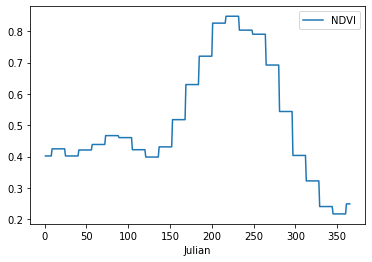

In [3]:
crop_data.plot('Julian', 'NDVI')

After plotting the graph I will define the growing season to where NDVI is above 0.5

Then I will quickly check the minimum and maximum 'Month' values (first and last) and this will give me a guide for the dates to specify. In this case it will be between June and October

In [4]:
growing_season = crop_data[crop_data['NDVI'] > 0.5]
growing_season['Month'].describe()

count    144.000000
mean       7.909722
std        1.368544
min        6.000000
25%        7.000000
50%        8.000000
75%        9.000000
max       10.000000
Name: Month, dtype: float64

# Load Landsat 7 thermal bands

After downloading the data from https://earthexplorer.usgs.gov/ using the specified dates above, its time to load and sort the data. I only need the thermal 2 band from each scene (In this case band 6-2). I will label them using the  aquisition date.

In [5]:
# create a list of paths
DN_tifs = glob.glob('thermal_data_2021/DNs/**/*B6_VCID_2.TIF', recursive=True)
DN_tifs.sort()

# create lit of dates
dates = list(os.walk('thermal_data_2021/DNs/'))[0]
dates = dates[1]
dates.sort()

In [6]:
# check list of paths to the relevant raster files
DN_tifs

['thermal_data_2021/DNs/20110505/LE07_L1TP_044033_20110505_20160914_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110521/LE07_L1TP_044033_20110521_20160914_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110622/LE07_L1TP_044033_20110622_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110724/LE07_L1TP_044033_20110724_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110809/LE07_L1TP_044033_20110809_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110825/LE07_L1TP_044033_20110825_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110910/LE07_L1TP_044033_20110910_20160913_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20110926/LE07_L1TP_044033_20110926_20160912_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20111012/LE07_L1TP_044033_20111012_20160912_01_T1_B6_VCID_2.TIF',
 'thermal_data_2021/DNs/20111028/LE07_L1TP_044033_20111028_20160912_01_T1_B6_VCID_2.TIF']

In [7]:
#check that is the correct amount
len(DN_tifs)

11

Next, I will visualise one raster to make sure everything looks correct. Throughout this exercise I will visualise the image from 8th July 2011 as it will likely have a good contrast with NDVI being high during this period.

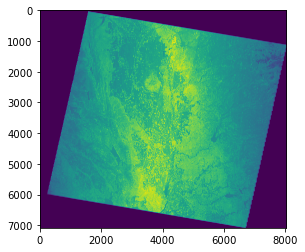

In [8]:
with rioxarray.open_rasterio('thermal_data_2021/DNs/20110708/LE07_L1TP_044033_20110708_20160913_01_T1_B6_VCID_2.TIF') as src:
    DN_layer = src

pyplot.imshow(DN_layer.squeeze())

In [9]:
DN_layer

<xarray.DataArray (band: 1, y: 7081, x: 8031)>
[56867511 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 4.926e+05 4.926e+05 ... 7.335e+05 7.335e+05
  * y            (y) float64 4.414e+06 4.414e+06 ... 4.201e+06 4.201e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

# Calculate Top of Atmosphere (TOA) Radiance

Here, I set the values required for the equation, taken from the MTL text file provided with the Landsat images. Then I define the function to pass the raster arrays to.

In [10]:
Lmax = 12.650
Lmin = 3.200
Qcalmax = 255
Qcalmin = 1

def TOA_radiance(DN):
    return (Lmax-Lmin) / (Qcalmax-Qcalmin) * (DN-Qcalmin) + Lmin


Next, I loop through each raster, run the calculation and save as a new raster.

In [11]:
# loop through images, calculate TOA Radiance and save to disc

for tif, date in zip(DN_tifs, dates):
    with rioxarray.open_rasterio(tif) as src:
        data = src
        
        # apply radiance equation
        data = TOA_radiance(data)
        
        # set the nodata value from max to min (mainly for visualisation)
        # cutoff taken from the max value of the provided sample raster
        data = data.where(data < 12.65, other = int(data.min()))

        # save to tif
        data.rio.to_raster(f'thermal_data_2021/TOA_Radiance/{date}_radiance.tif')

...and compare the new radiance values to the raw DNs with histograms.

(array([2.5599595e+07, 2.0400000e+02, 2.0200000e+02, 1.7308000e+04,
        1.1892900e+05, 4.2296900e+05, 9.5583140e+06, 1.0526616e+07,
        8.4845340e+06, 2.1388400e+06]),
 array([ 3.   ,  3.965,  4.93 ,  5.895,  6.86 ,  7.825,  8.79 ,  9.755,
        10.72 , 11.685, 12.65 ]),
 <BarContainer object of 10 artists>)

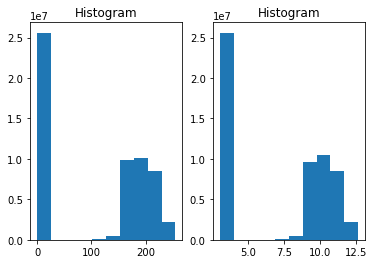

In [12]:
# compare DN to radiance values

#load the new radiance raster layer
with rioxarray.open_rasterio('thermal_data_2021/TOA_Radiance/20110708_radiance.tif') as src:
    RAD_layer = src


# plot histograms
fig, (ax1, ax2) = pyplot.subplots(1, 2)
ax1.set_title('Histogram of raw DNs')
DN_layer.plot.hist(ax=ax1)
ax2.set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=ax2)



# Calculate Top of Atmosphere (TOA) Brightness

Here, as above, I define the function to calculate TOA Brightness from my TOA Radiance rasters. (Note: I added the conversion from Kalvin to Degrees Centergrade to the end of the function). 

In [13]:
# define function to calculate Top of Atmosphere (TOA) brightness values

K1 = 666.09
K2 = 1282.71

def TOA_brightness(radiance):
    return (K2/(np.log(K1/radiance+1)))-272.15



...and again, loop through each raster, run the calculation and save as a new raster.

In [14]:
# loop through images, calculate TOA Brightness and save to disc
RAD_tifs = glob.glob('thermal_data_2021/TOA_Radiance/*.tif')
RAD_tifs.sort()

for tif, date in zip(RAD_tifs, dates):
    with rioxarray.open_rasterio(tif) as src:
        data = src
        
        #apply brightness equation
        data = TOA_brightness(data)
        
        #set the nodata value from max to min (mainly for visualisation)
        data = data.where(data < int(data.max()), other=int(data.min()))
        
        #save to tif
        data.rio.to_raster(f'thermal_data_2021/TOA_Brightness/{date}_brightness.tif')
       

Finally, I load and compare the raster to previous Radiance and Raw DN rasters.

(array([2.5614013e+07, 1.4100000e+02, 1.6800000e+02, 1.7200000e+02,
        1.1311000e+04, 1.2018900e+05, 5.2350200e+05, 1.2087921e+07,
        1.2252504e+07, 6.2575900e+06]),
 array([-34.93207099, -26.53951379, -18.14695659,  -9.75439939,
         -1.36184219,   7.03071501,  15.42327221,  23.81582941,
         32.20838662,  40.60094382,  48.99350102]),
 <BarContainer object of 10 artists>)

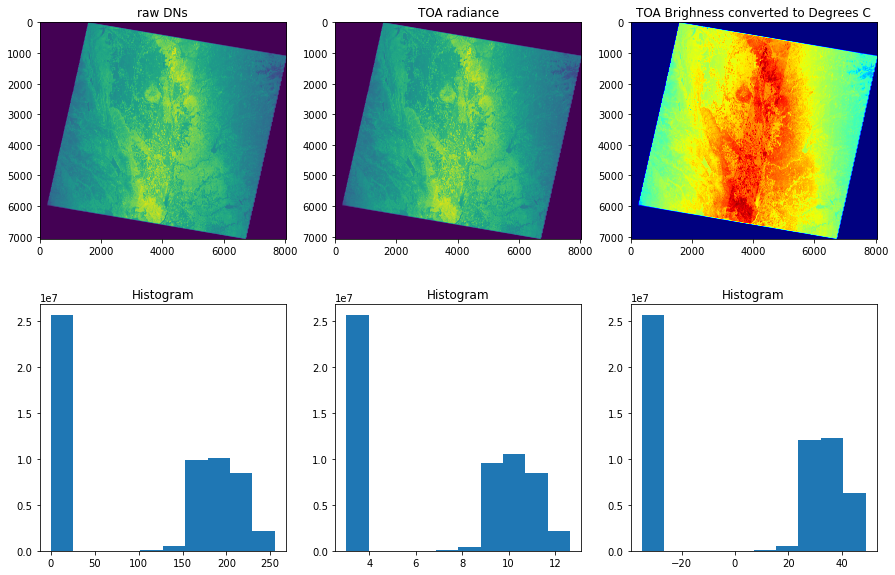

In [15]:
# using a single date for comparison (8 July 2011)

# load the raster file
with rioxarray.open_rasterio('thermal_data_2021/TOA_Brightness/20110708_brightness.tif') as src:
    BRI_layer = src


# plot the figures
fig, axs = pyplot.subplots(2, 3, figsize=(15,10))
axs[0,0].set_title('raw DNs')
axs[0,0].imshow(DN_layer.squeeze())
axs[0,1].set_title('TOA radiance')
axs[0,1].imshow(RAD_layer.squeeze())
axs[0,2].set_title('TOA Brighness converted to Degrees C')
axs[0,2].imshow(BRI_layer.squeeze(), cmap='jet')
axs[1,0].set_title('Histogram of DN values')
DN_layer.plot.hist(ax=axs[1,0])
axs[1,1].set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=axs[1,1])
axs[1,2].set_title('Histogram of TOA Brighness values (converted to Deg C)')
BRI_layer.plot.hist(ax=axs[1,2])


# Compare outputs with those provided in the exercise data

(array([2.5586065e+07, 1.9100000e+02, 1.9200000e+02, 2.4652000e+04,
        1.2090900e+05, 5.1096000e+05, 9.9211780e+06, 1.0076991e+07,
        8.4859990e+06, 2.1403740e+06]),
 array([ 3.1627953,  4.1115155,  5.060236 ,  6.0089564,  6.957677 ,
         7.9063973,  8.855118 ,  9.803839 , 10.752559 , 11.70128  ,
        12.65     ], dtype=float32),
 <BarContainer object of 10 artists>)

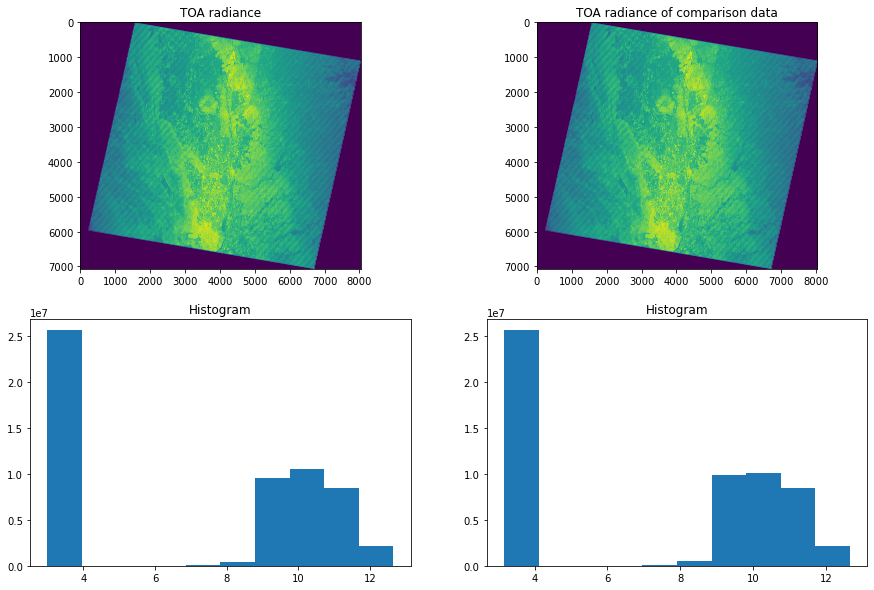

In [16]:
#compare TOA Radiance and TOA Brightness with sample tifs to ensure correct calculations

#open sample tiffs
with rioxarray.open_rasterio('thermal_data_2021/LS TOA/tifs/LS20110708TOA.tif') as src:
    sample_radiance = src

with rioxarray.open_rasterio('thermal_data_2021/LS Brighntess T/tifs/LS20110708degC.tif') as src:
    sample_brightness = src


# render raster and plot histograms of my and sample Radiance values

fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA radiance')
axs[0,0].imshow(RAD_layer.squeeze())
axs[1,0].set_title('Histogram of TOA radiance values')
RAD_layer.plot.hist(ax=axs[1,0])
axs[0,1].set_title('TOA radiance of comparison data')
axs[0,1].imshow(sample_radiance.squeeze())
axs[1,1].set_title('Histogram of TOA radiance values of comparison data')
sample_radiance.plot.hist(ax=axs[1,1])

(array([2.5585983e+07, 1.6300000e+02, 1.4600000e+02, 1.7300000e+02,
        2.8782000e+04, 1.2640000e+05, 1.3070760e+06, 1.3389492e+07,
        1.1522008e+07, 4.9072880e+06]),
 array([-33.60182  , -25.34863  , -17.09544  ,  -8.84225  ,  -0.5890595,
          7.664131 ,  15.917322 ,  24.170513 ,  32.423702 ,  40.676895 ,
         48.930084 ], dtype=float32),
 <BarContainer object of 10 artists>)

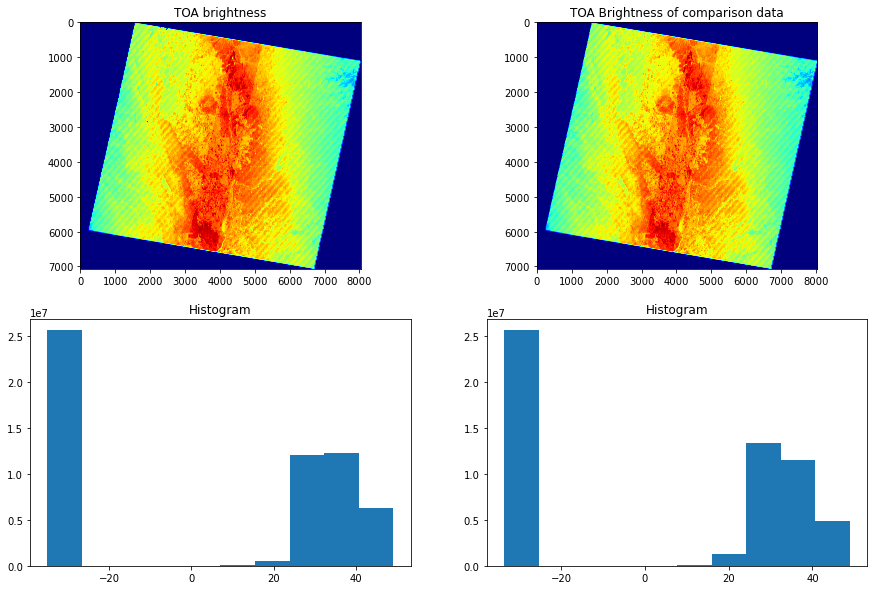

In [17]:
# render raster and plot histograms of my and sample Brightness values

fig, axs = pyplot.subplots(2, 2, figsize=(15,10))
axs[0,0].set_title('TOA brightness')
axs[0,0].imshow(BRI_layer.squeeze(), cmap='jet')
axs[1,0].set_title('Histogram of TOA brightness values')
BRI_layer.plot.hist(ax=axs[1,0])
axs[0,1].set_title('TOA Brightness of comparison data')
axs[0,1].imshow(sample_brightness.squeeze(), cmap='jet')
axs[1,1].set_title('Histogram of TOA brightness values of comparison data')
sample_brightness.plot.hist(ax=axs[1,1])

It appears that both version are basically identical.

Also, as requested in the exercise material, I visually compared and explored the Brightness raster with that of a False-colour image and also the cropscape image.

![Qgis Screenshot](cropscape_brighness_vis-compare.png)

# Track changes in TOA brightness temperature and evapotranspiration

Now to extract the brightness values from the rice field and add the data to the original excel file. I created a shapefile with a polygon within the rice feild using Qgis

In [18]:
# define the area of interest
AOI = gpd.read_file('thermal_data_2021/rice_field.shp')

#get list of brightness raster tifs
BRI_tifs = glob.glob('thermal_data_2021/TOA_Brightness/*.tif')
BRI_tifs.sort()

# collect and store mean brightness values along with julian date in a dictionary
Brightness_dict = {'brightness_value': [], 'Julian': []}

for tif, date in zip(BRI_tifs, dates):
    stats = zonal_stats(AOI, tif)
    Brightness_dict['brightness_value'].append(stats[0]['mean'])
    Brightness_dict['Julian'].append(pd.to_datetime(date).dayofyear)

# convert the dictionary to a Pandas dataframe and join to the crop data in the provided excel file
Brightness_values = pd.DataFrame.from_dict(Brightness_dict)

crop_data_merged = crop_data.merge(Brightness_values, on='Julian', how='inner')
crop_data_merged.sort_values('NDVI')

/home/dom/miniconda3/envs/geo_env/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


,Year,Month,Day,Julian,Unnamed: 4,crop.type,Tmx,Tmn,VPD,NDVI,EVI,ET,brightness_value
0,2011,5,5,125,855,NONE,26.737221,9.132681,1437.534658,0.398518,0.194817,1.407133,46.453491
10,2011,10,28,301,1031,NONE,24.495055,6.371960,714.441522,0.403608,0.267049,1.414723,19.308036
1,2011,5,21,141,871,RI,20.867021,9.489749,667.506136,0.430988,0.197686,3.877456,22.449376
9,2011,10,12,285,1015,RI,23.542754,10.698184,494.377091,0.543869,0.346607,2.044575,0.989808
2,2011,6,22,173,903,RI,31.318847,14.972199,1589.714047,0.629813,0.352129,5.219619,28.815385
8,2011,9,26,269,999,RI,28.839279,12.744380,968.076105,0.692144,0.448747,3.317633,-12.610389
3,2011,7,8,189,919,RI,32.561651,16.037669,1593.920394,0.720367,0.448725,5.466416,27.954399
7,2011,9,10,253,983,RI,30.824649,13.697373,1145.629919,0.790457,0.537510,4.715989,25.535725
6,2011,8,25,237,967,RI,29.433413,14.187724,1008.454493,0.803512,0.608201,5.211834,23.160949
4,2011,7,24,205,935,RI,27.235006,13.944144,864.844778,0.825871,0.576466,5.521123,22.189507


R-squared: 0.016829


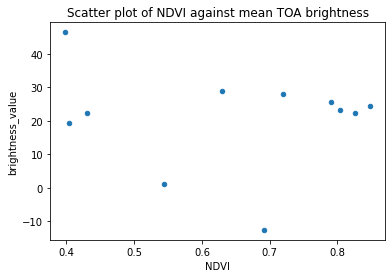

In [19]:
crop_data_merged.plot.scatter(x='NDVI', y='brightness_value', title='Scatter plot of NDVI against mean TOA brightness')

regression = linregress(crop_data_merged['NDVI'], crop_data_merged['brightness_value'])
print(f'R-squared: {regression.rvalue**2:.6f}')

R-squared: 0.015776


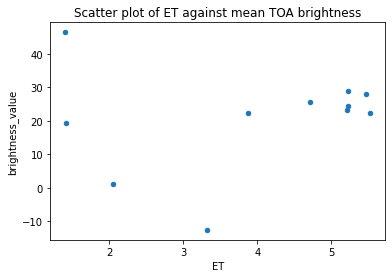

In [20]:
crop_data_merged.plot.scatter(x='ET', y='brightness_value', title='Scatter plot of ET against mean TOA brightness')

regression = linregress(crop_data_merged['ET'], crop_data_merged['brightness_value'])
print(f'R-squared: {regression.rvalue**2:.6f}')

After plotting the relationship between both NDVI and TOA Brightness and also NDVI and TOA Brighness, the results did not seem motivating. The mean brightness was taken from the entire maise field. I also tried using a smaller group of pixels and and a single pixel in the maise field but the results were similar each time. 
Apon inspection of the images with outliers I discovered that this streaking of the images can skew the reults from the value extraction as this will give the the minimum value within the raster (in this case -34).

# Conclusion

Unfortunaltely, due to the skewing of the results, the hypothysised inverse relationship between ET (and NDVI) and TOA Brigtness could not be produced and explored further. However as far as learning outcomes go, my time exploring the TOA Brightness rasters did show me the trend for vegetated areas such as crops and forests to have a lower latent than that of bare open ground, likely due to the cooling effect of evapotransiration. 